------------

# Generalization Full Scale Runner - Ready - 18/01/2023

### Generalization estimates how well the process model describes the (unknown) system, and not only the event log. If all parts of the process model are frequently used, the process model is likely to be generic. However, if some parts of the process model are rarely used, chances are high that the system actually allows for more behavior. Therefore we base the generalization measure on how often parts of the process model have been used while replaying the event log.

---------

### To Generate a Range of Generalization values between two Numbers

--------

#### Importing Libraries 

In [1]:
import os
import configparser
from datetime import date
import pandas as pd
import re
import graphviz
import math
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
#sns.set(style="darkgrid")

from tqdm import tqdm
from tqdm import trange


#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

-------

#### Profit Intialization

In [2]:
PATH = 'C:\\Users\\ashis\\Python Notebooks\\ProFIT'# path to ProFIT directory
config = configparser.ConfigParser()
config.add_section("packageLocation")
config.set("packageLocation", "workingDir", PATH)
config.set("packageLocation", "packageDir", PATH+'\\profit')


import sys
sys.path.append(config["packageLocation"]["workingDir"])
sys.path.append(config["packageLocation"]["packageDir"])


from profit import ProcessMap
pm = ProcessMap()

-----------

# Generalization Class

In [8]:
# GenSet is the class which holds all the methods required to perform Generalization Metric Generation 

class Genset:
    def __init__(self, IN_DATA, Act_Rate, Path_Rate):
        self.IN_DATA = IN_DATA                          # Data Input (LOG)
        self.Act_Rate = Act_Rate                        # Activity Rate 
        self.Path_Rate = Path_Rate                      # Path Rate
        
        
# Filter is used to Conver the NET_GRAPH Obtained from the Process Map into Computable Format.        
    def Filter(self,net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        return temp
    

# Final is used to Convert the NET_Graph obtained from the Process Map into Computable format of a Dataframe
    def Final(self, net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        HT = pd.DataFrame([x.split(' ') for x in temp.split('\n')])
        HT = HT.transpose()
        HT = HT.drop([0]).reset_index(drop = True)
        HT.columns = ['Task']
        HT= HT.drop(index=HT.index[-1])
        HT = HT.drop_duplicates(ignore_index=True)
        HT = HT.sort_values("Task").reset_index(drop = True)
        #print(HT)
    
        return HT 
    
    
# Activites Method produces a Dataframe of all the Events/Activites Present in the Dataset.
    def Activites(RAW): 
    
        A = (RAW.IN_DATA).copy()
        
        A.drop("case_id", inplace=True, axis = 1)       # To remove the Case_id Field from the Input
        A.drop("timestamp", inplace=True, axis = 1)     # To remove the timestamp Field from the Input
    
        A = A['task'].value_counts() # The frequency of each event is Generated. 
        # The Name of the field which contains the names of the 'Task' is supposed to be Subsituted (int the place of "TASK") incase it isnt the same.
        
        B = A.to_frame(name="Freq") # A Copy is Generated & converted from a text only format to a DataFrame. 
        
        B = B.rename_axis("Task").reset_index() # The Name "Task" here should remain the same as it is later utilized for merging of Dataframes
        
        
        # The Function "Filter" is used to make the Activity Labels uniform for both the Process Model & the Initial Event log
        for i in range(len(B)):
            temp_str_var = Obj.Filter(B.iloc[i,0])
            B.iloc[i,0] = temp_str_var
            # this loop extracts each string (Event Name), Filters & makes it uniform using the FILTER Function and then saves it back to the Dataframe
            
        return (B)

# This Function is used to Generate Process Maps for each instance     
    def MapGen(Log_DATA):
    
    
        pm.set_log(data = Log_DATA.IN_DATA) # The Input is the DataFrame
    
    
        # Have to change "Optimize" State when using Manual Path & Activity Rates
        pm.set_params(optimize=False,aggregate=False) # Optimize = TRUE/FALSE # Agg_type = inner/outer
    
    
        # Will be activated only when "OPTIMIZE" from above is changed to "False"
        pm.set_rates(activity_rate = Log_DATA.Act_Rate, path_rate = Log_DATA.Path_Rate) # Rates = Activity & Path rate only 
    
        # Logic on this (or in % , where 100% means complete utilization & 0% Vice Versa) 
        # Activity Rate = The precision/clarity of the model/graph being produced (i.e. when at 100 = all events are displayed, when at 5-10 low number of events with the most highest weightage are displayed)
        # Path rate = the regulation of paths (i.e. aggregation of path in %)0 = high aggregation of path, 100 % super detailed paths to every case/task
    
        pm.update() # Updates settings
    
        # pm.render() # Renders the Final Process Model (i.e. used to display, better to call it explicitly outside)
    
        print(pm.get_rates()) # Prints rates, this gives confirmation that the Rates have actually changed. 
    
        net = str(pm.get_graph()) #converts to String Type

        return net 
    
    
# This function is used to bring all the elements required for Generalization & Calculate the Final Rating of it
    def Generator(self, NETS, logger):
        
        Node_Extract = Obj.Final(NETS) # The Data from the Process Map
    
        Node_Extract = Node_Extract.rename(columns = {"concept:name":"Task"})  # Rename the input column name so that it can be relabeled to original
    
        log_data = logger.copy() # The Data From the LOG
        
        
        # initial part of Selecting the Activites that only occur in the Process Model & Attaching their respective Activites (Frequencies)
        MergedDF = pd.merge(Node_Extract, log_data, how='inner', on=None, left_on=None, right_on=None,
             left_index=False, right_index=False, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False,
             validate=None)
        # This Variable holds the Elements only present in the Process Map. (MergedDF = Process map(elements) + Frequency)
    
    
        # This Piece of code is used to calculate the SQRT Numerator Part of the Formula 
        # The Number of executions of each Event is accounted for & then The Root & inverse is calculated & reassigned back to its respective labels in the DataFrame
        for i in range(len(MergedDF)):
            TEMP = pow(math.sqrt(MergedDF.iloc[i,1]),-1)
            MergedDF.iloc[i,1] = TEMP
            
            
        # Final Numeric Generation using the Generalization formula. 
        # the Sum of all the frequencies is taken and divided by the Total Number of Nodes. 
        Gen = 1 - (MergedDF['Freq'].sum()/len(MergedDF))
    
        # A Value between 0 & 1 is returned. 
        return Gen

---------

## Data Input

In [9]:
df = pd.read_csv("remote_monitoring_eng.csv") #
df

,case_id,task,timestamp
0,4082,New med program operator,2018-01-10 00:00:03
1,4082,Red zone operator,2018-01-10 22:09:21
2,4173,New med program operator,2018-01-12 00:00:04
3,4176,New med program operator,2018-01-12 00:00:04
4,4082,Red zone doctor FD,2018-01-12 02:44:28
...,...,...,...
35606,9155,Notification operator,2018-12-31 09:03:14
35607,9362,Notification operator,2018-12-31 09:03:16
35608,9758,Notification operator,2018-12-31 09:03:23
35609,9938,Notification operator,2018-12-31 09:03:26


In [10]:
df["case_id"]

0         4082
1         4082
2         4173
3         4176
4         4082
         ...  
35606     9155
35607     9362
35608     9758
35609     9938
35610    10240
Name: case_id, Length: 35611, dtype: int64

In [11]:
df1 = df[df['task'] != 'New med program operator']
df1 = df1.reset_index(drop = True)

--------

## Actuation

---------------

### Generalization Calculation

#### Activity Rate =  VARIED
#### Path Rate      =  CONSTANT

In [12]:
Act = []   # To store the Activity Rate 
Gen = []   # To store the Calculated Generalization Value

PATH_THRES = [5,20,40,60,80,100] # The Steps of Path Rate required 


for j in trange(len(PATH_THRES)):
    
    
    # Reinitialization for every Step of the Path Rate mentioned
    Act = []
    Gen = []
    
    for i in trange(0,101,1): # Inner Runner Which Traverses the Activity Rate
        
        print("\n\n Rate of Activity = ", i," \n Rate of Path = ", PATH_THRES[j])
        
        Obj = Genset(df1, i, PATH_THRES[j]) # Creating Object for the Class # ACTIVITY (0-100), PATH (5,20,40,60,80,100) Const
    
        LOG = Obj.Activites() # Generating the Activites in the LOG
        
        Data_gen = Obj.MapGen() # Generating the Activities in the PROCESS MAP
        
        Gen_Final = Obj.Generator(Data_gen, LOG) # Generating the Generalization Rating
    
        #LIVE Printing If required.
        #print("\n\n The Generalization Rating for this Model = ", Gen_Final)
        #print("\n                         Or in Percentile = ", Gen_Final*100," % \n")
    
        # Storing
        Act.append(i)
        Gen.append(Gen_Final*100) # Converted into 0 - 100 scale (%)
        
        print("Generalization = ", Gen_Final*100)
        print("----------------------------------------------------NEXT-------------------------------------------------")
        
        
    # Saving it into Indiviudal Sections (i.e. for each Step of Path rate - a new Df is created)        
    print("----------------------------------------------------DONE-------------------------------------------------")
    
    if j == 0:
        res_af0 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
              
    elif j == 1:
        res_af1 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
           
    elif j == 2:
        res_af2 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 3:
        res_af3 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 4:
        res_af4 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    elif j == 5:
        res_af5 = pd.DataFrame({"Path_Rate":Act,"Generalization":Gen})
    
    
ACT_FULL = res_af0.copy()
ACT_FULL = ACT_FULL.merge(res_af1, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af2, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af3, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af4, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_af5, on='Path_Rate', how='right')

ACT_FULL.columns = ['Activity_Rate', 'Path = 5', 'Path = 20' ,'Path = 40', 'Path = 60','Path = 80','Path = 100']

ACT_FULL
        

  4%|███▏                                                                              | 4/101 [00:00<00:03, 31.85it/s]



 Rate of Activity =  0  
 Rate of Path =  5
{'activities': 0, 'paths': 5}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  5
{'activities': 1, 'paths': 5}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  5
{'activities': 2, 'paths': 5}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  5
{'activities': 3, 'paths': 5}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  4  
 Rate of Path =  5
{'activities': 4, 'paths': 5}
Generalization =  98.72664334746418
----------------


 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 33.05it/s]

Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  5
{'activities': 7, 'paths': 5}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  8  
 Rate of Path =  5
{'activities': 8, 'paths': 5}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  5
{'activities': 9, 'paths': 5}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  5
{'activities': 10, 'paths': 5}
Generalization =  98.72664334746418
----------------------------------------------------NEXT----------------------------------


 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.64it/s]

{'activities': 14, 'paths': 5}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  15  
 Rate of Path =  5
{'activities': 15, 'paths': 5}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  5
{'activities': 16, 'paths': 5}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  5
{'activities': 17, 'paths': 5}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  5
{'activities': 18, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 32.37it/s]

{'activities': 22, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  5
{'activities': 23, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  24  
 Rate of Path =  5
{'activities': 24, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  5
{'activities': 25, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  5
{'activities': 26, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------N


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 31.00it/s]


{'activities': 29, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  30  
 Rate of Path =  5
{'activities': 30, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  5
{'activities': 31, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  32  
 Rate of Path =  5
{'activities': 32, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  5
{'activities': 33, 'paths': 5}
Generalization =  98.54424362677022
----------------------------------------------------N

 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 30.86it/s]



 Rate of Activity =  36  
 Rate of Path =  5
{'activities': 36, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  5
{'activities': 37, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  5
{'activities': 38, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  39  
 Rate of Path =  5
{'activities': 39, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  5
{'activities': 40, 'paths': 5}
Generalization =  98.34404105692826
------


 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 30.75it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  5
{'activities': 43, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  44  
 Rate of Path =  5
{'activities': 44, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  5
{'activities': 45, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  5
{'activities': 46, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT----------------------------


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 30.34it/s]

{'activities': 50, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  51  
 Rate of Path =  5
{'activities': 51, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  52  
 Rate of Path =  5
{'activities': 52, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  5
{'activities': 53, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  5
{'activities': 54, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------N


 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 30.40it/s]


{'activities': 57, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  5
{'activities': 58, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  5
{'activities': 59, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  5
{'activities': 60, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  5
{'activities': 61, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------N

 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 31.74it/s]



 Rate of Activity =  64  
 Rate of Path =  5
{'activities': 64, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  65  
 Rate of Path =  5
{'activities': 65, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  5
{'activities': 66, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  5
{'activities': 67, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  5
{'activities': 68, 'paths': 5}
Generalization =  98.34404105692826
------


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 30.53it/s]

{'activities': 70, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  5
{'activities': 71, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  5
{'activities': 72, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  73  
 Rate of Path =  5
{'activities': 73, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  74  
 Rate of Path =  5
{'activities': 74, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------N


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 30.39it/s]


{'activities': 77, 'paths': 5}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  78  
 Rate of Path =  5
{'activities': 78, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  5
{'activities': 79, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  5
{'activities': 80, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  5
{'activities': 81, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------N

 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:02<00:00, 30.16it/s]



 Rate of Activity =  84  
 Rate of Path =  5
{'activities': 84, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  85  
 Rate of Path =  5
{'activities': 85, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  5
{'activities': 86, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  87  
 Rate of Path =  5
{'activities': 87, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  5
{'activities': 88, 'paths': 5}
Generalization =  95.28577856751484
------


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [00:03<00:00, 29.52it/s]

{'activities': 90, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  91  
 Rate of Path =  5
{'activities': 91, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  92  
 Rate of Path =  5
{'activities': 92, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  93  
 Rate of Path =  5
{'activities': 93, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  5
{'activities': 94, 'paths': 5}
Generalization =  95.28577856751484
----------------------------------------------------N


 17%|██████████████                                                                      | 1/6 [00:03<00:16,  3.30s/it]

{'activities': 97, 'paths': 5}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  98  
 Rate of Path =  5
{'activities': 98, 'paths': 5}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  99  
 Rate of Path =  5
{'activities': 99, 'paths': 5}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  5
{'activities': 100, 'paths': 5}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  0  
 Rate of Path =  20
{'activities': 0, 'paths': 20}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  20
{'activities': 1, 'paths': 20}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  20
{'activities': 2, 'paths': 20}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  20



  4%|███▏                                                                              | 4/101 [00:00<00:03, 32.00it/s]

{'activities': 3, 'paths': 20}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  4  
 Rate of Path =  20
{'activities': 4, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  20
{'activities': 5, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  6  
 Rate of Path =  20
{'activities': 6, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  20



  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.37it/s]

{'activities': 7, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  8  
 Rate of Path =  20
{'activities': 8, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  20
{'activities': 9, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  20



 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.32it/s]

{'activities': 10, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  11  
 Rate of Path =  20
{'activities': 11, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  12  
 Rate of Path =  20
{'activities': 12, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  13  
 Rate of Path =  20
{'activities': 13, 'paths': 20}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  14  
 Rate of Path =  20



 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 31.19it/s]

{'activities': 14, 'paths': 20}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  15  
 Rate of Path =  20
{'activities': 15, 'paths': 20}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  20
{'activities': 16, 'paths': 20}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  20



 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.12it/s]

{'activities': 17, 'paths': 20}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  20
{'activities': 18, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  19  
 Rate of Path =  20
{'activities': 19, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  20
{'activities': 20, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  21  
 Rate of Path =  20
{'activities': 21, 'paths': 20}
Generalization =  98.54424362677022
---------------------------------------------

{'activities': 22, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  20
{'activities': 23, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 30.84it/s]



 Rate of Activity =  24  
 Rate of Path =  20
{'activities': 24, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  20
{'activities': 25, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  20
{'activities': 26, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  27  
 Rate of Path =  20
{'activities': 27, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  28  
 Rate of Path =  20
{'activities': 28, 'paths': 20}
Generalization =  98.54424362677


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 30.82it/s]


{'activities': 30, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  20
{'activities': 31, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  32  
 Rate of Path =  20
{'activities': 32, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  20
{'activities': 33, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  34  
 Rate of Path =  20
{'activities': 34, 'paths': 20}
Generalization =  98.45663529130219
--------------------------------------------

 36%|████████████████████████████▊                                                    | 36/101 [00:01<00:02, 30.73it/s]



 Rate of Activity =  36  
 Rate of Path =  20
{'activities': 36, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  20



 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 30.66it/s]

{'activities': 37, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  20
{'activities': 38, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  39  
 Rate of Path =  20
{'activities': 39, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  20
{'activities': 40, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  41  
 Rate of Path =  20
{'activities': 41, 'paths': 20}
Generalization =  98.34404105692826
--------------------------------------------

{'activities': 42, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  20
{'activities': 43, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 30.58it/s]



 Rate of Activity =  44  
 Rate of Path =  20
{'activities': 44, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  20
{'activities': 45, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  20
{'activities': 46, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  47  
 Rate of Path =  20
{'activities': 47, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  48  
 Rate of Path =  20
{'activities': 48, 'paths': 20}
Generalization =  98.34404105692


 51%|█████████████████████████████████████████▋                                       | 52/101 [00:01<00:01, 30.57it/s]


{'activities': 50, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  51  
 Rate of Path =  20
{'activities': 51, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  52  
 Rate of Path =  20
{'activities': 52, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  20
{'activities': 53, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  20
{'activities': 54, 'paths': 20}
Generalization =  98.34404105692826
--------------------------------------------

 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 30.63it/s]



 Rate of Activity =  56  
 Rate of Path =  20
{'activities': 56, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  57  
 Rate of Path =  20



 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 30.75it/s]

{'activities': 57, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  20
{'activities': 58, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  20
{'activities': 59, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  20
{'activities': 60, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  20
{'activities': 61, 'paths': 20}
Generalization =  98.34404105692826
--------------------------------------------

{'activities': 62, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  63  
 Rate of Path =  20
{'activities': 63, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 31.05it/s]



 Rate of Activity =  64  
 Rate of Path =  20
{'activities': 64, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  65  
 Rate of Path =  20
{'activities': 65, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  20
{'activities': 66, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  20
{'activities': 67, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  20
{'activities': 68, 'paths': 20}
Generalization =  98.34404105692


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 31.20it/s]

{'activities': 70, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  20
{'activities': 71, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  20
{'activities': 72, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  73  
 Rate of Path =  20
{'activities': 73, 'paths': 20}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  74  
 Rate of Path =  20
{'activities': 74, 'paths': 20}
Generalization =  98.34404105692826
--------------------------------------------


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [00:02<00:00, 30.56it/s]

{'activities': 78, 'paths': 20}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  20
{'activities': 79, 'paths': 20}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  20
{'activities': 80, 'paths': 20}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  20
{'activities': 81, 'paths': 20}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  82  
 Rate of Path =  20
{'activities': 82, 'paths': 20}
Generalization =  97.29177340411573
--------------------------------------------


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:02<00:00, 30.19it/s]


{'activities': 85, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  20
{'activities': 86, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  87  
 Rate of Path =  20
{'activities': 87, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  20
{'activities': 88, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  89  
 Rate of Path =  20
{'activities': 89, 'paths': 20}
Generalization =  95.28577856751484
--------------------------------------------

 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [00:03<00:00, 29.91it/s]



 Rate of Activity =  92  
 Rate of Path =  20
{'activities': 92, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  93  
 Rate of Path =  20
{'activities': 93, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  20
{'activities': 94, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  95  
 Rate of Path =  20
{'activities': 95, 'paths': 20}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  96  
 Rate of Path =  20
{'activities': 96, 'paths': 20}
Generalization =  93.92835869501


 33%|████████████████████████████                                                        | 2/6 [00:06<00:13,  3.31s/it]

{'activities': 98, 'paths': 20}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  99  
 Rate of Path =  20
{'activities': 99, 'paths': 20}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  20
{'activities': 100, 'paths': 20}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]




 Rate of Activity =  0  
 Rate of Path =  40
{'activities': 0, 'paths': 40}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  40
{'activities': 1, 'paths': 40}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  40
{'activities': 2, 'paths': 40}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  40
{'activities': 3, 'paths': 40}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


  4%|███▏                                                                              | 4/101 [00:00<00:02, 33.99it/s]



 Rate of Activity =  4  
 Rate of Path =  40
{'activities': 4, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  40
{'activities': 5, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  6  
 Rate of Path =  40
{'activities': 6, 'paths': 40}



  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.72it/s]

Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  40
{'activities': 7, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  8  
 Rate of Path =  40
{'activities': 8, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  40
{'activities': 9, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  40
{'activities': 10, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT--------------------------


 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.73it/s]

{'activities': 11, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  12  
 Rate of Path =  40
{'activities': 12, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  13  
 Rate of Path =  40
{'activities': 13, 'paths': 40}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  14  
 Rate of Path =  40



 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 31.42it/s]

{'activities': 14, 'paths': 40}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  15  
 Rate of Path =  40
{'activities': 15, 'paths': 40}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  40
{'activities': 16, 'paths': 40}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  40
{'activities': 17, 'paths': 40}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  40



 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.11it/s]

{'activities': 18, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  19  
 Rate of Path =  40
{'activities': 19, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  40
{'activities': 20, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  21  
 Rate of Path =  40



 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 30.91it/s]

{'activities': 21, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  22  
 Rate of Path =  40
{'activities': 22, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  40
{'activities': 23, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  24  
 Rate of Path =  40
{'activities': 24, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  40


{'activities': 25, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  40
{'activities': 26, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  27  
 Rate of Path =  40
{'activities': 27, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 30.90it/s]




 Rate of Activity =  28  
 Rate of Path =  40
{'activities': 28, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  29  
 Rate of Path =  40
{'activities': 29, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  30  
 Rate of Path =  40
{'activities': 30, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  40
{'activities': 31, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 30.89it/s]



 Rate of Activity =  32  
 Rate of Path =  40
{'activities': 32, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  40
{'activities': 33, 'paths': 40}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  34  
 Rate of Path =  40



 36%|████████████████████████████▊                                                    | 36/101 [00:01<00:02, 30.74it/s]

{'activities': 34, 'paths': 40}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  35  
 Rate of Path =  40
{'activities': 35, 'paths': 40}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  36  
 Rate of Path =  40
{'activities': 36, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  40
{'activities': 37, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  40



 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 30.73it/s]

{'activities': 38, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  39  
 Rate of Path =  40
{'activities': 39, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  40
{'activities': 40, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  41  
 Rate of Path =  40
{'activities': 41, 'paths': 40}



 44%|███████████████████████████████████▎                                             | 44/101 [00:01<00:01, 30.62it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  42  
 Rate of Path =  40
{'activities': 42, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  40
{'activities': 43, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  44  
 Rate of Path =  40
{'activities': 44, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  40


{'activities': 45, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  40
{'activities': 46, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  47  
 Rate of Path =  40
{'activities': 47, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 30.67it/s]




 Rate of Activity =  48  
 Rate of Path =  40
{'activities': 48, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  49  
 Rate of Path =  40
{'activities': 49, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  50  
 Rate of Path =  40
{'activities': 50, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  51  
 Rate of Path =  40
{'activities': 51, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 51%|█████████████████████████████████████████▋                                       | 52/101 [00:01<00:01, 30.87it/s]



 Rate of Activity =  52  
 Rate of Path =  40
{'activities': 52, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  40
{'activities': 53, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  40
{'activities': 54, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  55  
 Rate of Path =  40



 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 30.57it/s]

{'activities': 55, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  56  
 Rate of Path =  40
{'activities': 56, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  57  
 Rate of Path =  40
{'activities': 57, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  40



 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 30.56it/s]

{'activities': 58, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  40
{'activities': 59, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  40
{'activities': 60, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  40
{'activities': 61, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  62  
 Rate of Path =  40
{'activities': 62, 'paths': 40}
Generalization =  98.34404105692826
--------------------------------------------


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 30.63it/s]

{'activities': 63, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  64  
 Rate of Path =  40
{'activities': 64, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  65  
 Rate of Path =  40
{'activities': 65, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  40



 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 30.60it/s]

{'activities': 66, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  40
{'activities': 67, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  40
{'activities': 68, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  69  
 Rate of Path =  40
{'activities': 69, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  70  
 Rate of Path =  40



 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [00:02<00:00, 30.51it/s]

{'activities': 70, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  40
{'activities': 71, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  40
{'activities': 72, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  73  
 Rate of Path =  40



 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 30.33it/s]

{'activities': 73, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  74  
 Rate of Path =  40
{'activities': 74, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  75  
 Rate of Path =  40
{'activities': 75, 'paths': 40}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  76  
 Rate of Path =  40
{'activities': 76, 'paths': 40}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  77  
 Rate of Path =  40


{'activities': 77, 'paths': 40}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  78  
 Rate of Path =  40
{'activities': 78, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  40
{'activities': 79, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 30.12it/s]



 Rate of Activity =  80  
 Rate of Path =  40
{'activities': 80, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  40
{'activities': 81, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  82  
 Rate of Path =  40
{'activities': 82, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  83  
 Rate of Path =  40
{'activities': 83, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------



 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [00:02<00:00, 29.89it/s]




 Rate of Activity =  84  
 Rate of Path =  40
{'activities': 84, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  85  
 Rate of Path =  40
{'activities': 85, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  40
{'activities': 86, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [00:02<00:00, 29.67it/s]




 Rate of Activity =  87  
 Rate of Path =  40
{'activities': 87, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  40
{'activities': 88, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  89  
 Rate of Path =  40
{'activities': 89, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [00:02<00:00, 29.57it/s]




 Rate of Activity =  90  
 Rate of Path =  40
{'activities': 90, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  91  
 Rate of Path =  40
{'activities': 91, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  92  
 Rate of Path =  40
{'activities': 92, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [00:03<00:00, 29.49it/s]




 Rate of Activity =  93  
 Rate of Path =  40
{'activities': 93, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  40
{'activities': 94, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  95  
 Rate of Path =  40
{'activities': 95, 'paths': 40}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [00:03<00:00, 29.34it/s]




 Rate of Activity =  96  
 Rate of Path =  40
{'activities': 96, 'paths': 40}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  97  
 Rate of Path =  40
{'activities': 97, 'paths': 40}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  98  
 Rate of Path =  40
{'activities': 98, 'paths': 40}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 50%|██████████████████████████████████████████                                          | 3/6 [00:09<00:09,  3.32s/it]



 Rate of Activity =  99  
 Rate of Path =  40
{'activities': 99, 'paths': 40}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  40
{'activities': 100, 'paths': 40}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  0  
 Rate of Path =  60
{'activities': 0, 'paths': 60}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  60



  4%|███▏                                                                              | 4/101 [00:00<00:02, 33.65it/s]

{'activities': 1, 'paths': 60}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  60
{'activities': 2, 'paths': 60}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  60
{'activities': 3, 'paths': 60}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------




 Rate of Activity =  4  
 Rate of Path =  60
{'activities': 4, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  60
{'activities': 5, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  6  
 Rate of Path =  60


{'activities': 6, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  60
{'activities': 7, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.73it/s]



 Rate of Activity =  8  
 Rate of Path =  60
{'activities': 8, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  60
{'activities': 9, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  60



 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.55it/s]

{'activities': 10, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  11  
 Rate of Path =  60
{'activities': 11, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  12  
 Rate of Path =  60
{'activities': 12, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  13  
 Rate of Path =  60
{'activities': 13, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  14  
 Rate of Path =  60



 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 31.42it/s]

{'activities': 14, 'paths': 60}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  15  
 Rate of Path =  60
{'activities': 15, 'paths': 60}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  60
{'activities': 16, 'paths': 60}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  60
{'activities': 17, 'paths': 60}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  60



 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.09it/s]

{'activities': 18, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  19  
 Rate of Path =  60
{'activities': 19, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  60
{'activities': 20, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  21  
 Rate of Path =  60



 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 30.67it/s]

{'activities': 21, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  22  
 Rate of Path =  60
{'activities': 22, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  60
{'activities': 23, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  24  
 Rate of Path =  60


{'activities': 24, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  60
{'activities': 25, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  60
{'activities': 26, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  27  
 Rate of Path =  60
{'activities': 27, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 30.86it/s]



 Rate of Activity =  28  
 Rate of Path =  60
{'activities': 28, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  29  
 Rate of Path =  60
{'activities': 29, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  30  
 Rate of Path =  60
{'activities': 30, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  60



 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 30.41it/s]

{'activities': 31, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  32  
 Rate of Path =  60
{'activities': 32, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  60
{'activities': 33, 'paths': 60}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  34  
 Rate of Path =  60
{'activities': 34, 'paths': 60}



 36%|████████████████████████████▊                                                    | 36/101 [00:01<00:02, 30.30it/s]

Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  35  
 Rate of Path =  60
{'activities': 35, 'paths': 60}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  36  
 Rate of Path =  60
{'activities': 36, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  60
{'activities': 37, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  60



 40%|████████████████████████████████                                                 | 40/101 [00:01<00:02, 30.08it/s]

{'activities': 38, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  39  
 Rate of Path =  60
{'activities': 39, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  60
{'activities': 40, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  41  
 Rate of Path =  60



 44%|███████████████████████████████████▎                                             | 44/101 [00:01<00:01, 29.99it/s]

{'activities': 41, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  42  
 Rate of Path =  60
{'activities': 42, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  60
{'activities': 43, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  44  
 Rate of Path =  60
{'activities': 44, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  60



 47%|█████████████████████████████████████▋                                           | 47/101 [00:01<00:01, 29.74it/s]

{'activities': 45, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  60
{'activities': 46, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  47  
 Rate of Path =  60
{'activities': 47, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  48  
 Rate of Path =  60
{'activities': 48, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  49  
 Rate of Path =  60



 50%|████████████████████████████████████████                                         | 50/101 [00:01<00:01, 29.65it/s]

{'activities': 49, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  50  
 Rate of Path =  60
{'activities': 50, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  51  
 Rate of Path =  60
{'activities': 51, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  52  
 Rate of Path =  60



 53%|███████████████████████████████████████████▎                                     | 54/101 [00:01<00:01, 29.73it/s]

{'activities': 52, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  60
{'activities': 53, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  60
{'activities': 54, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  55  
 Rate of Path =  60
{'activities': 55, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  56  
 Rate of Path =  60



 56%|█████████████████████████████████████████████▋                                   | 57/101 [00:01<00:01, 29.71it/s]

{'activities': 56, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  57  
 Rate of Path =  60
{'activities': 57, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  60
{'activities': 58, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  60



 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 29.65it/s]

{'activities': 59, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  60
{'activities': 60, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  60
{'activities': 61, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  62  
 Rate of Path =  60
{'activities': 62, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  63  
 Rate of Path =  60
{'activities': 63, 'paths': 60}



 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 29.76it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  64  
 Rate of Path =  60
{'activities': 64, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  65  
 Rate of Path =  60
{'activities': 65, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  60
{'activities': 66, 'paths': 60}



 66%|█████████████████████████████████████████████████████▋                           | 67/101 [00:02<00:01, 29.69it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  60
{'activities': 67, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  60
{'activities': 68, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  69  
 Rate of Path =  60
{'activities': 69, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [00:02<00:01, 29.75it/s]




 Rate of Activity =  70  
 Rate of Path =  60
{'activities': 70, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  60
{'activities': 71, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  60
{'activities': 72, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [00:02<00:00, 29.67it/s]



 Rate of Activity =  73  
 Rate of Path =  60
{'activities': 73, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  74  
 Rate of Path =  60
{'activities': 74, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  75  
 Rate of Path =  60
{'activities': 75, 'paths': 60}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  76  
 Rate of Path =  60



 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [00:02<00:00, 29.50it/s]

{'activities': 76, 'paths': 60}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  77  
 Rate of Path =  60
{'activities': 77, 'paths': 60}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  78  
 Rate of Path =  60
{'activities': 78, 'paths': 60}



 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 29.13it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  60
{'activities': 79, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  60
{'activities': 80, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  60
{'activities': 81, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  82  
 Rate of Path =  60
{'activities': 82, 'paths': 60}



 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [00:02<00:00, 29.07it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  83  
 Rate of Path =  60
{'activities': 83, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  84  
 Rate of Path =  60
{'activities': 84, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  85  
 Rate of Path =  60



 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [00:02<00:00, 28.75it/s]


{'activities': 85, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  60
{'activities': 86, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  87  
 Rate of Path =  60
{'activities': 87, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  60
{'activities': 88, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [00:02<00:00, 28.83it/s]



 Rate of Activity =  89  
 Rate of Path =  60
{'activities': 89, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  90  
 Rate of Path =  60
{'activities': 90, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  91  
 Rate of Path =  60
{'activities': 91, 'paths': 60}



 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [00:03<00:00, 28.56it/s]


Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  92  
 Rate of Path =  60
{'activities': 92, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  93  
 Rate of Path =  60
{'activities': 93, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  60
{'activities': 94, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [00:03<00:00, 28.88it/s]



 Rate of Activity =  95  
 Rate of Path =  60
{'activities': 95, 'paths': 60}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  96  
 Rate of Path =  60
{'activities': 96, 'paths': 60}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  97  
 Rate of Path =  60
{'activities': 97, 'paths': 60}



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [00:03<00:00, 28.37it/s]

Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  98  
 Rate of Path =  60
{'activities': 98, 'paths': 60}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  99  
 Rate of Path =  60
{'activities': 99, 'paths': 60}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  60



 67%|████████████████████████████████████████████████████████                            | 4/6 [00:13<00:06,  3.35s/it]

{'activities': 100, 'paths': 60}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  0  
 Rate of Path =  80
{'activities': 0, 'paths': 80}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  80
{'activities': 1, 'paths': 80}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  80
{'activities': 2, 'paths': 80}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  80



  4%|███▏                                                                              | 4/101 [00:00<00:03, 31.74it/s]

{'activities': 3, 'paths': 80}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  4  
 Rate of Path =  80
{'activities': 4, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  80
{'activities': 5, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  6  
 Rate of Path =  80
{'activities': 6, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  80



  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.44it/s]

{'activities': 7, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  8  
 Rate of Path =  80
{'activities': 8, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  80
{'activities': 9, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  80
{'activities': 10, 'paths': 80}



 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.61it/s]

Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  11  
 Rate of Path =  80
{'activities': 11, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  12  
 Rate of Path =  80
{'activities': 12, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  13  
 Rate of Path =  80
{'activities': 13, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  14  
 Rate of Path =  80
{'activities': 14, 'paths': 80}
Generalization =  98.5525016016476
----------------------------------------------------NEXT---------------------


 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 31.48it/s]

{'activities': 15, 'paths': 80}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  80
{'activities': 16, 'paths': 80}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  80
{'activities': 17, 'paths': 80}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  80



 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.05it/s]

{'activities': 18, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  19  
 Rate of Path =  80
{'activities': 19, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  80
{'activities': 20, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  21  
 Rate of Path =  80
{'activities': 21, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  22  
 Rate of Path =  80



 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 30.67it/s]

{'activities': 22, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  80
{'activities': 23, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  24  
 Rate of Path =  80
{'activities': 24, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  80



 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 30.84it/s]

{'activities': 25, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  80
{'activities': 26, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  27  
 Rate of Path =  80
{'activities': 27, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  28  
 Rate of Path =  80
{'activities': 28, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  29  
 Rate of Path =  80


{'activities': 29, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  30  
 Rate of Path =  80
{'activities': 30, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  80
{'activities': 31, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 30.37it/s]




 Rate of Activity =  32  
 Rate of Path =  80
{'activities': 32, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  80
{'activities': 33, 'paths': 80}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  34  
 Rate of Path =  80
{'activities': 34, 'paths': 80}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  35  
 Rate of Path =  80
{'activities': 35, 'paths': 80}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 36%|████████████████████████████▊                                                    | 36/101 [00:01<00:02, 30.42it/s]



 Rate of Activity =  36  
 Rate of Path =  80
{'activities': 36, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  80
{'activities': 37, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  80



 40%|████████████████████████████████                                                 | 40/101 [00:01<00:02, 30.30it/s]

{'activities': 38, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  39  
 Rate of Path =  80
{'activities': 39, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  80
{'activities': 40, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  41  
 Rate of Path =  80
{'activities': 41, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  42  
 Rate of Path =  80



 44%|███████████████████████████████████▎                                             | 44/101 [00:01<00:01, 29.92it/s]

{'activities': 42, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  80
{'activities': 43, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  44  
 Rate of Path =  80
{'activities': 44, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  80



 47%|█████████████████████████████████████▋                                           | 47/101 [00:01<00:01, 29.69it/s]

{'activities': 45, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  80
{'activities': 46, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  47  
 Rate of Path =  80
{'activities': 47, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  48  
 Rate of Path =  80
{'activities': 48, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  49  
 Rate of Path =  80



 50%|████████████████████████████████████████                                         | 50/101 [00:01<00:01, 29.48it/s]

{'activities': 49, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  50  
 Rate of Path =  80
{'activities': 50, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  51  
 Rate of Path =  80
{'activities': 51, 'paths': 80}



 52%|██████████████████████████████████████████▌                                      | 53/101 [00:01<00:01, 29.29it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  52  
 Rate of Path =  80
{'activities': 52, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  80
{'activities': 53, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  80
{'activities': 54, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  55  
 Rate of Path =  80
{'activities': 55, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT--------------------

 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 29.26it/s]



 Rate of Activity =  56  
 Rate of Path =  80
{'activities': 56, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  57  
 Rate of Path =  80
{'activities': 57, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  80



 58%|███████████████████████████████████████████████▎                                 | 59/101 [00:01<00:01, 29.12it/s]


{'activities': 58, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  80
{'activities': 59, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  80
{'activities': 60, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  80
{'activities': 61, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 61%|█████████████████████████████████████████████████▋                               | 62/101 [00:02<00:01, 29.21it/s]




 Rate of Activity =  62  
 Rate of Path =  80
{'activities': 62, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  63  
 Rate of Path =  80
{'activities': 63, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  64  
 Rate of Path =  80
{'activities': 64, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 64%|████████████████████████████████████████████████████▏                            | 65/101 [00:02<00:01, 28.97it/s]



 Rate of Activity =  65  
 Rate of Path =  80
{'activities': 65, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  80
{'activities': 66, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  80
{'activities': 67, 'paths': 80}



 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 29.02it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  80
{'activities': 68, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  69  
 Rate of Path =  80
{'activities': 69, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  70  
 Rate of Path =  80
{'activities': 70, 'paths': 80}



 70%|████████████████████████████████████████████████████████▉                        | 71/101 [00:02<00:01, 29.02it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  80
{'activities': 71, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  80
{'activities': 72, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  73  
 Rate of Path =  80
{'activities': 73, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [00:02<00:00, 29.23it/s]




 Rate of Activity =  74  
 Rate of Path =  80
{'activities': 74, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  75  
 Rate of Path =  80
{'activities': 75, 'paths': 80}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  76  
 Rate of Path =  80
{'activities': 76, 'paths': 80}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [00:02<00:00, 29.32it/s]



 Rate of Activity =  77  
 Rate of Path =  80
{'activities': 77, 'paths': 80}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  78  
 Rate of Path =  80
{'activities': 78, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  80
{'activities': 79, 'paths': 80}



 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 28.84it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  80
{'activities': 80, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  80
{'activities': 81, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  82  
 Rate of Path =  80
{'activities': 82, 'paths': 80}



 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [00:02<00:00, 28.49it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  83  
 Rate of Path =  80
{'activities': 83, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  84  
 Rate of Path =  80
{'activities': 84, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  85  
 Rate of Path =  80
{'activities': 85, 'paths': 80}



 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [00:02<00:00, 28.28it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  80
{'activities': 86, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  87  
 Rate of Path =  80
{'activities': 87, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  80
{'activities': 88, 'paths': 80}



 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [00:03<00:00, 28.14it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  89  
 Rate of Path =  80
{'activities': 89, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  90  
 Rate of Path =  80
{'activities': 90, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  91  
 Rate of Path =  80
{'activities': 91, 'paths': 80}



 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [00:03<00:00, 27.83it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  92  
 Rate of Path =  80
{'activities': 92, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  93  
 Rate of Path =  80
{'activities': 93, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  80
{'activities': 94, 'paths': 80}



 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [00:03<00:00, 27.73it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  95  
 Rate of Path =  80
{'activities': 95, 'paths': 80}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  96  
 Rate of Path =  80
{'activities': 96, 'paths': 80}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  97  
 Rate of Path =  80
{'activities': 97, 'paths': 80}



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [00:03<00:00, 27.45it/s]


Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  98  
 Rate of Path =  80
{'activities': 98, 'paths': 80}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  99  
 Rate of Path =  80
{'activities': 99, 'paths': 80}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  80
{'activities': 100, 'paths': 80}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:16<00:03,  3.39s/it]

----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  0  
 Rate of Path =  100
{'activities': 0, 'paths': 100}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  1  
 Rate of Path =  100
{'activities': 1, 'paths': 100}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  2  
 Rate of Path =  100
{'activities': 2, 'paths': 100}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  3  
 Rate of Path =  100



  4%|███▏                                                                              | 4/101 [00:00<00:03, 32.22it/s]

{'activities': 3, 'paths': 100}
Generalization =  98.77839341201778
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  4  
 Rate of Path =  100
{'activities': 4, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  100
{'activities': 5, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  6  
 Rate of Path =  100
{'activities': 6, 'paths': 100}


  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.91it/s]


Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  7  
 Rate of Path =  100
{'activities': 7, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  8  
 Rate of Path =  100
{'activities': 8, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  9  
 Rate of Path =  100
{'activities': 9, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  10  
 Rate of Path =  100
{'activities': 10, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-----------------


 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.54it/s]

{'activities': 11, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  12  
 Rate of Path =  100
{'activities': 12, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  13  
 Rate of Path =  100
{'activities': 13, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  14  
 Rate of Path =  100



 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 31.69it/s]

{'activities': 14, 'paths': 100}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  15  
 Rate of Path =  100
{'activities': 15, 'paths': 100}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  16  
 Rate of Path =  100
{'activities': 16, 'paths': 100}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  17  
 Rate of Path =  100
{'activities': 17, 'paths': 100}
Generalization =  98.5525016016476
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  18  
 Rate of Path =  100
{'activities': 18, 'paths': 100}



 20%|████████████████                                                                 | 20/101 [00:00<00:02, 30.68it/s]

Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  19  
 Rate of Path =  100
{'activities': 19, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  100
{'activities': 20, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  21  
 Rate of Path =  100



 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 30.31it/s]

{'activities': 21, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  22  
 Rate of Path =  100
{'activities': 22, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  23  
 Rate of Path =  100
{'activities': 23, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  24  
 Rate of Path =  100
{'activities': 24, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  25  
 Rate of Path =  100


{'activities': 25, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  26  
 Rate of Path =  100
{'activities': 26, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  27  
 Rate of Path =  100
{'activities': 27, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 31%|████████████████████████▊                                                        | 31/101 [00:01<00:02, 29.87it/s]



 Rate of Activity =  28  
 Rate of Path =  100
{'activities': 28, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  29  
 Rate of Path =  100
{'activities': 29, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  30  
 Rate of Path =  100
{'activities': 30, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  31  
 Rate of Path =  100
{'activities': 31, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  32  
 Rate of Path =  100


{'activities': 32, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  33  
 Rate of Path =  100
{'activities': 33, 'paths': 100}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 38%|██████████████████████████████▍                                                  | 38/101 [00:01<00:02, 30.38it/s]



 Rate of Activity =  34  
 Rate of Path =  100
{'activities': 34, 'paths': 100}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  35  
 Rate of Path =  100
{'activities': 35, 'paths': 100}
Generalization =  98.45663529130219
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  36  
 Rate of Path =  100
{'activities': 36, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  37  
 Rate of Path =  100
{'activities': 37, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  38  
 Rate of Path =  100
{'activities': 38, 'paths': 100}
Generalization =  98.3


 42%|█████████████████████████████████▋                                               | 42/101 [00:01<00:02, 28.47it/s]

{'activities': 40, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  41  
 Rate of Path =  100
{'activities': 41, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  42  
 Rate of Path =  100
{'activities': 42, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  43  
 Rate of Path =  100
{'activities': 43, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  44  
 Rate of Path =  100
{'activities': 44, 'paths': 100}



 45%|████████████████████████████████████                                             | 45/101 [00:01<00:01, 28.26it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  45  
 Rate of Path =  100
{'activities': 45, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  46  
 Rate of Path =  100
{'activities': 46, 'paths': 100}



 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 28.01it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  47  
 Rate of Path =  100
{'activities': 47, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  48  
 Rate of Path =  100
{'activities': 48, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  49  
 Rate of Path =  100
{'activities': 49, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  50  
 Rate of Path =  100
{'activities': 50, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT------------

 50%|████████████████████████████████████████▉                                        | 51/101 [00:01<00:01, 27.96it/s]



 Rate of Activity =  51  
 Rate of Path =  100
{'activities': 51, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  52  
 Rate of Path =  100



 53%|███████████████████████████████████████████▎                                     | 54/101 [00:01<00:01, 27.76it/s]


{'activities': 52, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  53  
 Rate of Path =  100
{'activities': 53, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  54  
 Rate of Path =  100
{'activities': 54, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  55  
 Rate of Path =  100
{'activities': 55, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  56  
 Rate of Path =  100
{'activities': 56, 'paths': 100}
Generalization =  98.34404105692826
-----------------------------------

 56%|█████████████████████████████████████████████▋                                   | 57/101 [00:01<00:01, 27.78it/s]



 Rate of Activity =  57  
 Rate of Path =  100
{'activities': 57, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  58  
 Rate of Path =  100
{'activities': 58, 'paths': 100}



 59%|████████████████████████████████████████████████                                 | 60/101 [00:02<00:01, 27.83it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  59  
 Rate of Path =  100
{'activities': 59, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  100
{'activities': 60, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  61  
 Rate of Path =  100
{'activities': 61, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  62  
 Rate of Path =  100
{'activities': 62, 'paths': 100}



 62%|██████████████████████████████████████████████████▌                              | 63/101 [00:02<00:01, 27.74it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  63  
 Rate of Path =  100
{'activities': 63, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  64  
 Rate of Path =  100
{'activities': 64, 'paths': 100}



 65%|████████████████████████████████████████████████████▉                            | 66/101 [00:02<00:01, 27.67it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  65  
 Rate of Path =  100
{'activities': 65, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  66  
 Rate of Path =  100
{'activities': 66, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  67  
 Rate of Path =  100
{'activities': 67, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  68  
 Rate of Path =  100
{'activities': 68, 'paths': 100}



 68%|███████████████████████████████████████████████████████▎                         | 69/101 [00:02<00:01, 27.69it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  69  
 Rate of Path =  100
{'activities': 69, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  70  
 Rate of Path =  100
{'activities': 70, 'paths': 100}



 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [00:02<00:01, 27.82it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  71  
 Rate of Path =  100
{'activities': 71, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  72  
 Rate of Path =  100
{'activities': 72, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  73  
 Rate of Path =  100
{'activities': 73, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  74  
 Rate of Path =  100
{'activities': 74, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT------------

 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [00:02<00:00, 27.85it/s]



 Rate of Activity =  75  
 Rate of Path =  100
{'activities': 75, 'paths': 100}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  76  
 Rate of Path =  100
{'activities': 76, 'paths': 100}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  77  
 Rate of Path =  100



 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [00:02<00:00, 27.60it/s]

{'activities': 77, 'paths': 100}
Generalization =  98.19602854801002
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  78  
 Rate of Path =  100
{'activities': 78, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  79  
 Rate of Path =  100
{'activities': 79, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  100
{'activities': 80, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  81  
 Rate of Path =  100



 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [00:02<00:00, 27.07it/s]

{'activities': 81, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  82  
 Rate of Path =  100
{'activities': 82, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  83  
 Rate of Path =  100



 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [00:02<00:00, 26.94it/s]

{'activities': 83, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  84  
 Rate of Path =  100
{'activities': 84, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  85  
 Rate of Path =  100
{'activities': 85, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  86  
 Rate of Path =  100
{'activities': 86, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  87  
 Rate of Path =  100
{'activities': 87, 'paths': 100}



 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:03<00:00, 26.44it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  88  
 Rate of Path =  100
{'activities': 88, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  89  
 Rate of Path =  100
{'activities': 89, 'paths': 100}



 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [00:03<00:00, 26.10it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  90  
 Rate of Path =  100
{'activities': 90, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  91  
 Rate of Path =  100
{'activities': 91, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  92  
 Rate of Path =  100
{'activities': 92, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  93  
 Rate of Path =  100
{'activities': 93, 'paths': 100}



 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [00:03<00:00, 25.88it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  94  
 Rate of Path =  100
{'activities': 94, 'paths': 100}
Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  95  
 Rate of Path =  100
{'activities': 95, 'paths': 100}



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [00:03<00:00, 25.64it/s]

Generalization =  95.28577856751484
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  96  
 Rate of Path =  100
{'activities': 96, 'paths': 100}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  97  
 Rate of Path =  100
{'activities': 97, 'paths': 100}
Generalization =  93.92835869501384
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  98  
 Rate of Path =  100
{'activities': 98, 'paths': 100}
Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  99  
 Rate of Path =  100
{'activities': 99, 'paths': 100}



100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 27.94it/s]

Generalization =  90.71775960797515
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  100
{'activities': 100, 'paths': 100}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.40s/it]
C:\Users\ashis\AppData\Local\Temp\ipykernel_37032\4294559798.py:61: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_af3, on='Path_Rate', how='right')


----------------------------------------------------DONE-------------------------------------------------


C:\Users\ashis\AppData\Local\Temp\ipykernel_37032\4294559798.py:63: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_af5, on='Path_Rate', how='right')


,Activity_Rate,Path = 5,Path = 20,Path = 40,Path = 60,Path = 80,Path = 100
0,0,98.778393,98.778393,98.778393,98.778393,98.778393,98.778393
1,1,98.778393,98.778393,98.778393,98.778393,98.778393,98.778393
2,2,98.778393,98.778393,98.778393,98.778393,98.778393,98.778393
3,3,98.778393,98.778393,98.778393,98.778393,98.778393,98.778393
4,4,98.726643,98.726643,98.726643,98.726643,98.726643,98.726643
...,...,...,...,...,...,...,...
96,96,93.928359,93.928359,93.928359,93.928359,93.928359,93.928359
97,97,93.928359,93.928359,93.928359,93.928359,93.928359,93.928359
98,98,90.717760,90.717760,90.717760,90.717760,90.717760,90.717760
99,99,90.717760,90.717760,90.717760,90.717760,90.717760,90.717760


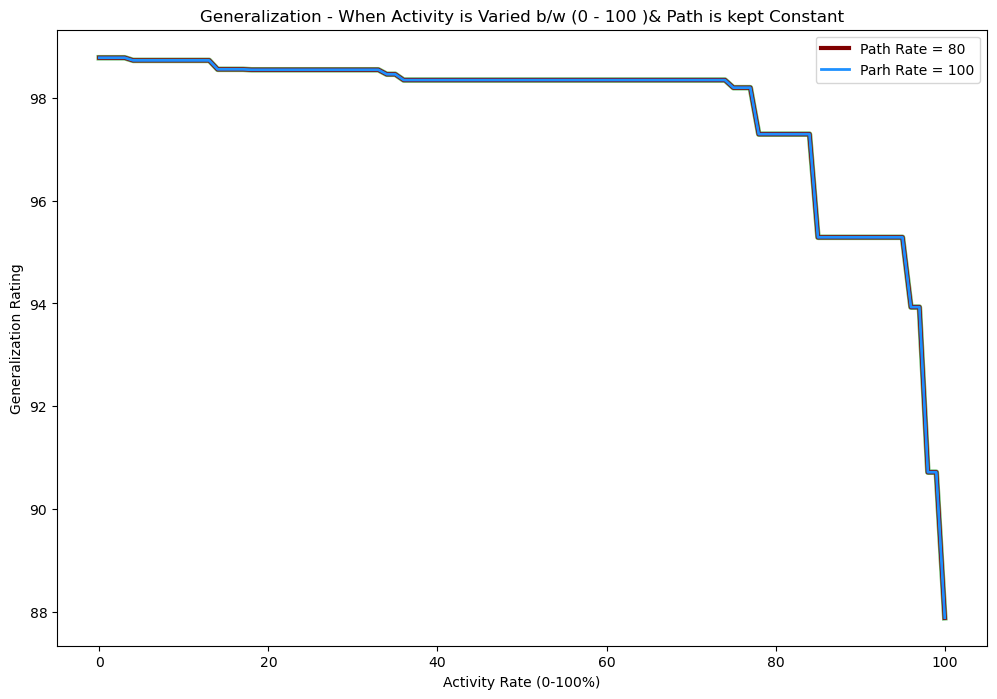

In [14]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af0, lw = 2, color = 'blue')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af1, lw = 2, color = 'yellow')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Path_Rate', y='Generalization', data=res_af5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Activity Rate (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

In [ ]:
ACT_FULL.to_csv("Sample_5_Generalization_ACT.csv")

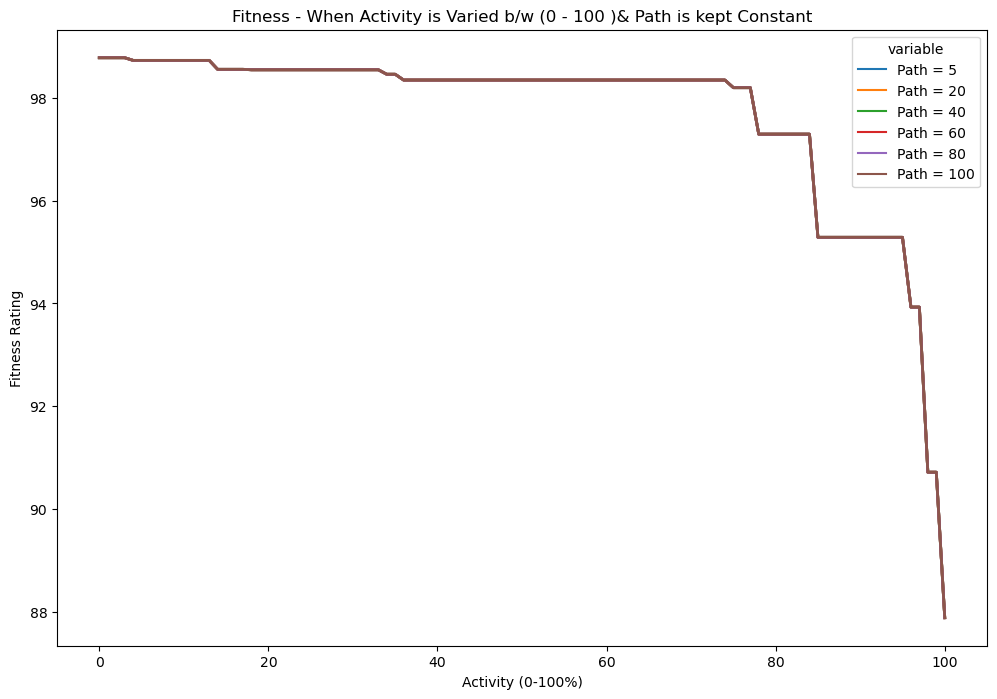

In [13]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

----------------

### Generalization Calculation

#### Activity Rate =  CONSTANT
#### Path Rate      =  VARIED

In [15]:
Path = []  # To store the Path Rate 
Gen = []   # To store the Calculated Generalization Value


ACT_THRES = [5,20,40,60,80,100] # The Steps of Activity Rate required 


for j in trange(len(ACT_THRES)):
    
    # Reinitialization for every Step of the Activity Rate mentioned
    Path = []
    Gen = []
    
    for i in trange(0,101,1): # Inner Runner Which Traverses the Path Rate
        
        print("\n\n Rate of Activity = ", ACT_THRES[j]," \n Rate of Path = ", i)
        
        Obj = Genset(df1, ACT_THRES[j], i) # Creating Object for the Class # ACTIVITY (5,20,40,60,80,100) Const, PATH (0-100) 
    
        LOG = Obj.Activites() # Generating the Activites in the LOG
        
        Data_gen = Obj.MapGen() # Generating the Activites in the PROCESS MODEL
        
        Gen_Final = Obj.Generator(Data_gen, LOG) # Generating the Generalization Rating
        
        #LIVE Printing If required.
        #print("\n\n The Generalization Rating for this Model = ", Gen_Final)
        #print("\n                         Or in Percentile = ", Gen_Final*100," % \n")
    
        # Storing
        Path.append(i)
        Gen.append(Gen_Final*100)# Converted into 0 - 100 scale (%)
        
        print("Generalization = ", Gen_Final*100)
        print("----------------------------------------------------NEXT-------------------------------------------------")

        
    # Saving it into Indiviudal Sections (i.e. for each Step of Path rate - a new Df is created)
    print("----------------------------------------------------DONE-------------------------------------------------")
    
    if j == 0:
        res_df0 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
        
    elif j == 1:
        res_df1 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 2:
        res_df2 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 3:
        res_df3 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 4:
        res_df4 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
    elif j == 5:
        res_df5 = pd.DataFrame({"Activity_rate":Path,"Generalization":Gen})
    
# Merging all the Data into one Variable      
PATH_FULL = res_df0.copy()
PATH_FULL = PATH_FULL.merge(res_df1, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df2, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df3, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df4, on='Activity_rate', how='right')
PATH_FULL = PATH_FULL.merge(res_df5, on='Activity_rate', how='right')

# Renaming the Columns 
PATH_FULL.columns = ['Path_Rate', 'Activity = 5', 'Activity = 20' ,'Activity = 40', 'Activity = 60','Activity = 80','Activity = 100']

# Printing Final Output
PATH_FULL
        

  4%|███▏                                                                              | 4/101 [00:00<00:03, 32.11it/s]



 Rate of Activity =  5  
 Rate of Path =  0
{'activities': 5, 'paths': 0}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  1
{'activities': 5, 'paths': 1}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  2
{'activities': 5, 'paths': 2}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  3
{'activities': 5, 'paths': 3}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  4
{'activities': 5, 'paths': 4}
Generalization =  98.72664334746418
----------------


 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 32.52it/s]

{'activities': 5, 'paths': 7}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  8
{'activities': 5, 'paths': 8}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  9
{'activities': 5, 'paths': 9}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  10
{'activities': 5, 'paths': 10}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  11
{'activities': 5, 'paths': 11}
Generalization =  98.72664334746418
----------------------------------------------------NEXT--


 20%|████████████████                                                                 | 20/101 [00:00<00:02, 32.07it/s]

Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  15
{'activities': 5, 'paths': 15}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  16
{'activities': 5, 'paths': 16}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  17
{'activities': 5, 'paths': 17}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  18
{'activities': 5, 'paths': 18}
Generalization =  98.72664334746418
----------------------------------------------------NEXT----------------------------


 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 31.65it/s]


Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  22
{'activities': 5, 'paths': 22}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  23
{'activities': 5, 'paths': 23}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  24
{'activities': 5, 'paths': 24}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  25
{'activities': 5, 'paths': 25}
Generalization =  98.72664334746418
----------------------------------------------------NEXT----------------------------

 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 31.32it/s]



 Rate of Activity =  5  
 Rate of Path =  28
{'activities': 5, 'paths': 28}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  29
{'activities': 5, 'paths': 29}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  30
{'activities': 5, 'paths': 30}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  31
{'activities': 5, 'paths': 31}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  32
{'activities': 5, 'paths': 32}
Generalization =  98.72664334746418
------


 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 31.31it/s]

{'activities': 5, 'paths': 34}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  35
{'activities': 5, 'paths': 35}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  36
{'activities': 5, 'paths': 36}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  37
{'activities': 5, 'paths': 37}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  38
{'activities': 5, 'paths': 38}
Generalization =  98.72664334746418
----------------------------------------------------N


 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 31.66it/s]

{'activities': 5, 'paths': 42}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  43
{'activities': 5, 'paths': 43}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  44
{'activities': 5, 'paths': 44}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  45
{'activities': 5, 'paths': 45}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  46
{'activities': 5, 'paths': 46}
Generalization =  98.72664334746418
----------------------------------------------------N


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 31.40it/s]

{'activities': 5, 'paths': 50}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  51
{'activities': 5, 'paths': 51}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  52
{'activities': 5, 'paths': 52}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  53
{'activities': 5, 'paths': 53}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  54
{'activities': 5, 'paths': 54}
Generalization =  98.72664334746418
----------------------------------------------------N


 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 31.10it/s]


{'activities': 5, 'paths': 57}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  58
{'activities': 5, 'paths': 58}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  59
{'activities': 5, 'paths': 59}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  60
{'activities': 5, 'paths': 60}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  61
{'activities': 5, 'paths': 61}
Generalization =  98.72664334746418
----------------------------------------------------N

 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 31.28it/s]



 Rate of Activity =  5  
 Rate of Path =  64
{'activities': 5, 'paths': 64}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  65
{'activities': 5, 'paths': 65}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  66
{'activities': 5, 'paths': 66}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  67
{'activities': 5, 'paths': 67}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  68
{'activities': 5, 'paths': 68}
Generalization =  98.72664334746418
------


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 31.28it/s]

{'activities': 5, 'paths': 71}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  72
{'activities': 5, 'paths': 72}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  73
{'activities': 5, 'paths': 73}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  74
{'activities': 5, 'paths': 74}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  75
{'activities': 5, 'paths': 75}
Generalization =  98.72664334746418
----------------------------------------------------N


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [00:02<00:00, 31.04it/s]

{'activities': 5, 'paths': 78}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  79
{'activities': 5, 'paths': 79}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  80
{'activities': 5, 'paths': 80}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  81
{'activities': 5, 'paths': 81}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  82
{'activities': 5, 'paths': 82}
Generalization =  98.72664334746418
----------------------------------------------------N


 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [00:02<00:00, 30.80it/s]

{'activities': 5, 'paths': 86}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  87
{'activities': 5, 'paths': 87}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  88
{'activities': 5, 'paths': 88}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  89
{'activities': 5, 'paths': 89}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  90
{'activities': 5, 'paths': 90}
Generalization =  98.72664334746418
----------------------------------------------------N


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [00:03<00:00, 30.93it/s]


{'activities': 5, 'paths': 93}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  94
{'activities': 5, 'paths': 94}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  95
{'activities': 5, 'paths': 95}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  96
{'activities': 5, 'paths': 96}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  5  
 Rate of Path =  97
{'activities': 5, 'paths': 97}
Generalization =  98.72664334746418
----------------------------------------------------N

 17%|██████████████                                                                      | 1/6 [00:03<00:16,  3.23s/it]



 Rate of Activity =  5  
 Rate of Path =  100
{'activities': 5, 'paths': 100}
Generalization =  98.72664334746418
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  4%|███▏                                                                              | 4/101 [00:00<00:03, 31.65it/s]



 Rate of Activity =  20  
 Rate of Path =  0
{'activities': 20, 'paths': 0}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  1
{'activities': 20, 'paths': 1}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  2
{'activities': 20, 'paths': 2}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  3
{'activities': 20, 'paths': 3}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  4
{'activities': 20, 'paths': 4}
Generalization =  98.54424362677022
------


  8%|██████▍                                                                           | 8/101 [00:00<00:02, 31.28it/s]


Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  6
{'activities': 20, 'paths': 6}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  7
{'activities': 20, 'paths': 7}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  8
{'activities': 20, 'paths': 8}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  9
{'activities': 20, 'paths': 9}
Generalization =  98.54424362677022
----------------------------------------------------NEXT----------------------------

 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 32.67it/s]



 Rate of Activity =  20  
 Rate of Path =  12
{'activities': 20, 'paths': 12}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  13
{'activities': 20, 'paths': 13}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  14
{'activities': 20, 'paths': 14}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  15
{'activities': 20, 'paths': 15}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  16
{'activities': 20, 'paths': 16}
Generalization =  98.54424362677


 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 31.21it/s]

{'activities': 20, 'paths': 19}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  20
{'activities': 20, 'paths': 20}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  21
{'activities': 20, 'paths': 21}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  22
{'activities': 20, 'paths': 22}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  23
{'activities': 20, 'paths': 23}
Generalization =  98.54424362677022
--------------------------------------------


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 31.68it/s]

Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  27
{'activities': 20, 'paths': 27}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  28
{'activities': 20, 'paths': 28}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  29
{'activities': 20, 'paths': 29}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  30
{'activities': 20, 'paths': 30}
Generalization =  98.54424362677022
----------------------------------------------------NEXT--------------------


 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 30.63it/s]

{'activities': 20, 'paths': 34}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  35
{'activities': 20, 'paths': 35}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  36
{'activities': 20, 'paths': 36}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  37
{'activities': 20, 'paths': 37}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  38
{'activities': 20, 'paths': 38}
Generalization =  98.54424362677022
--------------------------------------------


 44%|███████████████████████████████████▎                                             | 44/101 [00:01<00:01, 30.59it/s]


Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  42
{'activities': 20, 'paths': 42}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  43
{'activities': 20, 'paths': 43}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  44
{'activities': 20, 'paths': 44}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  45
{'activities': 20, 'paths': 45}
Generalization =  98.54424362677022
----------------------------------------------------NEXT--------------------

 51%|█████████████████████████████████████████▋                                       | 52/101 [00:01<00:01, 30.61it/s]



 Rate of Activity =  20  
 Rate of Path =  48
{'activities': 20, 'paths': 48}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  49
{'activities': 20, 'paths': 49}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  50
{'activities': 20, 'paths': 50}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  51
{'activities': 20, 'paths': 51}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  52
{'activities': 20, 'paths': 52}
Generalization =  98.54424362677


 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 30.64it/s]

{'activities': 20, 'paths': 54}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  55
{'activities': 20, 'paths': 55}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  56
{'activities': 20, 'paths': 56}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  57
{'activities': 20, 'paths': 57}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  58
{'activities': 20, 'paths': 58}
Generalization =  98.54424362677022
--------------------------------------------


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 30.04it/s]


{'activities': 20, 'paths': 61}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  62
{'activities': 20, 'paths': 62}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  63
{'activities': 20, 'paths': 63}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  64
{'activities': 20, 'paths': 64}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  65
{'activities': 20, 'paths': 65}
Generalization =  98.54424362677022
--------------------------------------------

 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [00:02<00:00, 30.31it/s]



 Rate of Activity =  20  
 Rate of Path =  68
{'activities': 20, 'paths': 68}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  69
{'activities': 20, 'paths': 69}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  70
{'activities': 20, 'paths': 70}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  71
{'activities': 20, 'paths': 71}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  72
{'activities': 20, 'paths': 72}
Generalization =  98.54424362677


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 30.51it/s]

{'activities': 20, 'paths': 74}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  75
{'activities': 20, 'paths': 75}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  76
{'activities': 20, 'paths': 76}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  77
{'activities': 20, 'paths': 77}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  78
{'activities': 20, 'paths': 78}
Generalization =  98.54424362677022
--------------------------------------------


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [00:02<00:00, 29.67it/s]

{'activities': 20, 'paths': 82}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  83
{'activities': 20, 'paths': 83}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  84
{'activities': 20, 'paths': 84}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  85
{'activities': 20, 'paths': 85}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  86
{'activities': 20, 'paths': 86}
Generalization =  98.54424362677022
--------------------------------------------


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [00:03<00:00, 29.82it/s]



 Rate of Activity =  20  
 Rate of Path =  90
{'activities': 20, 'paths': 90}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  91
{'activities': 20, 'paths': 91}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  92
{'activities': 20, 'paths': 92}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  93
{'activities': 20, 'paths': 93}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  94
{'activities': 20, 'paths': 94}
Generalization =  98.54424362677


 33%|████████████████████████████                                                        | 2/6 [00:06<00:13,  3.28s/it]

{'activities': 20, 'paths': 96}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  97
{'activities': 20, 'paths': 97}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  98
{'activities': 20, 'paths': 98}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  99
{'activities': 20, 'paths': 99}
Generalization =  98.54424362677022
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  20  
 Rate of Path =  100
{'activities': 20, 'paths': 100}
Generalization =  98.54424362677022
------------------------------------------


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  40  
 Rate of Path =  0
{'activities': 40, 'paths': 0}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  1
{'activities': 40, 'paths': 1}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  2
{'activities': 40, 'paths': 2}



  4%|███▏                                                                              | 4/101 [00:00<00:03, 31.10it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  3
{'activities': 40, 'paths': 3}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  4
{'activities': 40, 'paths': 4}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  5
{'activities': 40, 'paths': 5}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  6
{'activities': 40, 'paths': 6}
Generalization =  98.34404105692826
----------------------------------------------------NEXT----------------------------


  8%|██████▍                                                                           | 8/101 [00:00<00:03, 30.86it/s]

{'activities': 40, 'paths': 7}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  8
{'activities': 40, 'paths': 8}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  9



 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 30.71it/s]

{'activities': 40, 'paths': 9}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  10
{'activities': 40, 'paths': 10}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  11
{'activities': 40, 'paths': 11}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  12
{'activities': 40, 'paths': 12}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  13
{'activities': 40, 'paths': 13}
Generalization =  98.34404105692826
---------------------------------------------

{'activities': 40, 'paths': 14}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  15
{'activities': 40, 'paths': 15}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 20%|████████████████                                                                 | 20/101 [00:00<00:02, 30.70it/s]



 Rate of Activity =  40  
 Rate of Path =  16
{'activities': 40, 'paths': 16}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  17
{'activities': 40, 'paths': 17}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  18
{'activities': 40, 'paths': 18}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  19
{'activities': 40, 'paths': 19}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  20
{'activities': 40, 'paths': 20}
Generalization =  98.34404105692


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 31.10it/s]

{'activities': 40, 'paths': 22}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  23
{'activities': 40, 'paths': 23}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  24
{'activities': 40, 'paths': 24}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  25
{'activities': 40, 'paths': 25}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  26
{'activities': 40, 'paths': 26}
Generalization =  98.34404105692826
--------------------------------------------


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 30.58it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  30
{'activities': 40, 'paths': 30}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  31
{'activities': 40, 'paths': 31}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  32
{'activities': 40, 'paths': 32}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  33
{'activities': 40, 'paths': 33}
Generalization =  98.34404105692826
----------------------------------------------------NEXT--------------------

 40%|████████████████████████████████                                                 | 40/101 [00:01<00:01, 30.76it/s]



 Rate of Activity =  40  
 Rate of Path =  36
{'activities': 40, 'paths': 36}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  37
{'activities': 40, 'paths': 37}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  38
{'activities': 40, 'paths': 38}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  39
{'activities': 40, 'paths': 39}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  40
{'activities': 40, 'paths': 40}
Generalization =  98.34404105692


 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 30.29it/s]

{'activities': 40, 'paths': 43}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  44
{'activities': 40, 'paths': 44}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  45
{'activities': 40, 'paths': 45}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  46
{'activities': 40, 'paths': 46}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  47
{'activities': 40, 'paths': 47}
Generalization =  98.34404105692826
--------------------------------------------


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 30.33it/s]

{'activities': 40, 'paths': 50}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  51
{'activities': 40, 'paths': 51}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  52
{'activities': 40, 'paths': 52}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  53
{'activities': 40, 'paths': 53}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  54
{'activities': 40, 'paths': 54}
Generalization =  98.34404105692826
--------------------------------------------


 59%|████████████████████████████████████████████████                                 | 60/101 [00:01<00:01, 30.08it/s]


{'activities': 40, 'paths': 57}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  58
{'activities': 40, 'paths': 58}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  59
{'activities': 40, 'paths': 59}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  60
{'activities': 40, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  61
{'activities': 40, 'paths': 61}
Generalization =  98.34404105692826
--------------------------------------------

 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:02<00:01, 30.10it/s]



 Rate of Activity =  40  
 Rate of Path =  64
{'activities': 40, 'paths': 64}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  65
{'activities': 40, 'paths': 65}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  66
{'activities': 40, 'paths': 66}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  67
{'activities': 40, 'paths': 67}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  68
{'activities': 40, 'paths': 68}
Generalization =  98.34404105692


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 30.04it/s]

{'activities': 40, 'paths': 70}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  71
{'activities': 40, 'paths': 71}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  72
{'activities': 40, 'paths': 72}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  73
{'activities': 40, 'paths': 73}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  74
{'activities': 40, 'paths': 74}
Generalization =  98.34404105692826
--------------------------------------------


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:02<00:00, 29.71it/s]


{'activities': 40, 'paths': 77}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  78
{'activities': 40, 'paths': 78}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  79
{'activities': 40, 'paths': 79}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  80
{'activities': 40, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  81
{'activities': 40, 'paths': 81}
Generalization =  98.34404105692826
--------------------------------------------

 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [00:02<00:00, 29.25it/s]




 Rate of Activity =  40  
 Rate of Path =  83
{'activities': 40, 'paths': 83}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  84
{'activities': 40, 'paths': 84}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  85
{'activities': 40, 'paths': 85}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  86
{'activities': 40, 'paths': 86}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  87
{'activities': 40, 'paths': 87}
Generalization =  98.34404105692

 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [00:03<00:00, 29.24it/s]



 Rate of Activity =  40  
 Rate of Path =  89
{'activities': 40, 'paths': 89}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  90
{'activities': 40, 'paths': 90}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  91
{'activities': 40, 'paths': 91}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  92
{'activities': 40, 'paths': 92}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  93
{'activities': 40, 'paths': 93}
Generalization =  98.34404105692


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [00:03<00:00, 28.75it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  95
{'activities': 40, 'paths': 95}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  96
{'activities': 40, 'paths': 96}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  97
{'activities': 40, 'paths': 97}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  40  
 Rate of Path =  98
{'activities': 40, 'paths': 98}
Generalization =  98.34404105692826
----------------------------------------------------NEXT--------------------

 50%|██████████████████████████████████████████                                          | 3/6 [00:09<00:09,  3.32s/it]

----------------------------------------------------DONE-------------------------------------------------



  4%|███▏                                                                              | 4/101 [00:00<00:03, 31.60it/s]



 Rate of Activity =  60  
 Rate of Path =  0
{'activities': 60, 'paths': 0}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  1
{'activities': 60, 'paths': 1}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  2
{'activities': 60, 'paths': 2}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  3
{'activities': 60, 'paths': 3}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  4
{'activities': 60, 'paths': 4}
Generalization =  98.34404105692826
------


 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 31.11it/s]

{'activities': 60, 'paths': 7}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  8
{'activities': 60, 'paths': 8}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  9
{'activities': 60, 'paths': 9}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  10
{'activities': 60, 'paths': 10}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  11
{'activities': 60, 'paths': 11}
Generalization =  98.34404105692826
-------------------------------------------------


 20%|████████████████                                                                 | 20/101 [00:00<00:02, 31.06it/s]

{'activities': 60, 'paths': 15}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  16
{'activities': 60, 'paths': 16}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  17
{'activities': 60, 'paths': 17}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  18
{'activities': 60, 'paths': 18}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  19
{'activities': 60, 'paths': 19}
Generalization =  98.34404105692826
--------------------------------------------


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 31.07it/s]

{'activities': 60, 'paths': 23}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  24
{'activities': 60, 'paths': 24}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  25
{'activities': 60, 'paths': 25}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  26
{'activities': 60, 'paths': 26}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  27
{'activities': 60, 'paths': 27}
Generalization =  98.34404105692826
--------------------------------------------


 36%|████████████████████████████▊                                                    | 36/101 [00:01<00:02, 30.84it/s]

Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  31
{'activities': 60, 'paths': 31}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  32
{'activities': 60, 'paths': 32}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  33
{'activities': 60, 'paths': 33}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  34
{'activities': 60, 'paths': 34}
Generalization =  98.34404105692826
----------------------------------------------------NEXT--------------------


 40%|████████████████████████████████                                                 | 40/101 [00:01<00:02, 30.44it/s]


{'activities': 60, 'paths': 37}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  38
{'activities': 60, 'paths': 38}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  39
{'activities': 60, 'paths': 39}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  40
{'activities': 60, 'paths': 40}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  41
{'activities': 60, 'paths': 41}
Generalization =  98.34404105692826
--------------------------------------------

 48%|██████████████████████████████████████▍                                          | 48/101 [00:01<00:01, 30.52it/s]



 Rate of Activity =  60  
 Rate of Path =  44
{'activities': 60, 'paths': 44}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  45
{'activities': 60, 'paths': 45}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  46
{'activities': 60, 'paths': 46}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  47
{'activities': 60, 'paths': 47}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  48
{'activities': 60, 'paths': 48}
Generalization =  98.34404105692


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:01<00:01, 30.52it/s]

{'activities': 60, 'paths': 51}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  52
{'activities': 60, 'paths': 52}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  53
{'activities': 60, 'paths': 53}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  54
{'activities': 60, 'paths': 54}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  55
{'activities': 60, 'paths': 55}
Generalization =  98.34404105692826
--------------------------------------------


 62%|██████████████████████████████████████████████████▌                              | 63/101 [00:02<00:01, 29.97it/s]

{'activities': 60, 'paths': 58}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  59
{'activities': 60, 'paths': 59}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  60
{'activities': 60, 'paths': 60}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  61
{'activities': 60, 'paths': 61}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  62
{'activities': 60, 'paths': 62}
Generalization =  98.34404105692826
--------------------------------------------


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [00:02<00:01, 29.73it/s]


{'activities': 60, 'paths': 65}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  66
{'activities': 60, 'paths': 66}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  67
{'activities': 60, 'paths': 67}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  68
{'activities': 60, 'paths': 68}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  69
{'activities': 60, 'paths': 69}
Generalization =  98.34404105692826
--------------------------------------------

 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 29.68it/s]



 Rate of Activity =  60  
 Rate of Path =  72
{'activities': 60, 'paths': 72}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  73
{'activities': 60, 'paths': 73}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  74
{'activities': 60, 'paths': 74}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  75
{'activities': 60, 'paths': 75}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  76
{'activities': 60, 'paths': 76}
Generalization =  98.34404105692


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [00:02<00:00, 29.60it/s]


Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  79
{'activities': 60, 'paths': 79}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  80
{'activities': 60, 'paths': 80}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  81
{'activities': 60, 'paths': 81}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  82
{'activities': 60, 'paths': 82}
Generalization =  98.34404105692826
----------------------------------------------------NEXT--------------------

 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [00:02<00:00, 29.69it/s]



 Rate of Activity =  60  
 Rate of Path =  85
{'activities': 60, 'paths': 85}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  86
{'activities': 60, 'paths': 86}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  87
{'activities': 60, 'paths': 87}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  88
{'activities': 60, 'paths': 88}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  89
{'activities': 60, 'paths': 89}
Generalization =  98.34404105692


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [00:03<00:00, 29.15it/s]

{'activities': 60, 'paths': 91}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  92
{'activities': 60, 'paths': 92}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  93
{'activities': 60, 'paths': 93}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  94
{'activities': 60, 'paths': 94}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  95
{'activities': 60, 'paths': 95}
Generalization =  98.34404105692826
--------------------------------------------


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:13<00:06,  3.34s/it]

{'activities': 60, 'paths': 98}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  99
{'activities': 60, 'paths': 99}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  60  
 Rate of Path =  100
{'activities': 60, 'paths': 100}
Generalization =  98.34404105692826
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  80  
 Rate of Path =  0
{'activities': 80, 'paths': 0}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  1
{'activities': 80, 'paths': 1}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  2
{'activities': 80, 'paths': 2}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  3
{'activities': 80, 'paths': 3}



  4%|███▏                                                                              | 4/101 [00:00<00:03, 30.33it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  4
{'activities': 80, 'paths': 4}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  5
{'activities': 80, 'paths': 5}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  6



  8%|██████▍                                                                           | 8/101 [00:00<00:03, 30.31it/s]

{'activities': 80, 'paths': 6}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  7
{'activities': 80, 'paths': 7}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  8
{'activities': 80, 'paths': 8}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  9
{'activities': 80, 'paths': 9}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  10



 12%|█████████▌                                                                       | 12/101 [00:00<00:02, 30.25it/s]

{'activities': 80, 'paths': 10}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  11
{'activities': 80, 'paths': 11}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  12
{'activities': 80, 'paths': 12}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  13



 16%|████████████▊                                                                    | 16/101 [00:00<00:02, 30.54it/s]

{'activities': 80, 'paths': 13}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  14
{'activities': 80, 'paths': 14}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  15
{'activities': 80, 'paths': 15}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  16
{'activities': 80, 'paths': 16}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  17
{'activities': 80, 'paths': 17}
Generalization =  97.29177340411573
--------------------------------------------

{'activities': 80, 'paths': 18}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  19
{'activities': 80, 'paths': 19}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 24%|███████████████████▏                                                             | 24/101 [00:00<00:02, 30.37it/s]



 Rate of Activity =  80  
 Rate of Path =  20
{'activities': 80, 'paths': 20}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  21
{'activities': 80, 'paths': 21}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  22
{'activities': 80, 'paths': 22}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  23
{'activities': 80, 'paths': 23}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  24
{'activities': 80, 'paths': 24}
Generalization =  97.29177340411


 32%|█████████████████████████▋                                                       | 32/101 [00:01<00:02, 29.94it/s]

{'activities': 80, 'paths': 26}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  27
{'activities': 80, 'paths': 27}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  28
{'activities': 80, 'paths': 28}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  29
{'activities': 80, 'paths': 29}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  30
{'activities': 80, 'paths': 30}
Generalization =  97.29177340411573
--------------------------------------------


 38%|██████████████████████████████▍                                                  | 38/101 [00:01<00:02, 29.80it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  33
{'activities': 80, 'paths': 33}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  34
{'activities': 80, 'paths': 34}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  35
{'activities': 80, 'paths': 35}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  36
{'activities': 80, 'paths': 36}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 45%|████████████████████████████████████                                             | 45/101 [00:01<00:01, 29.94it/s]

{'activities': 80, 'paths': 39}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  40
{'activities': 80, 'paths': 40}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  41
{'activities': 80, 'paths': 41}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  42
{'activities': 80, 'paths': 42}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  43
{'activities': 80, 'paths': 43}
Generalization =  97.29177340411573
--------------------------------------------


 51%|█████████████████████████████████████████▋                                       | 52/101 [00:01<00:01, 29.88it/s]

{'activities': 80, 'paths': 46}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  47
{'activities': 80, 'paths': 47}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  48
{'activities': 80, 'paths': 48}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  49
{'activities': 80, 'paths': 49}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  50
{'activities': 80, 'paths': 50}
Generalization =  97.29177340411573
--------------------------------------------


 57%|██████████████████████████████████████████████▌                                  | 58/101 [00:01<00:01, 29.31it/s]

{'activities': 80, 'paths': 53}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  54
{'activities': 80, 'paths': 54}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  55
{'activities': 80, 'paths': 55}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  56
{'activities': 80, 'paths': 56}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  57
{'activities': 80, 'paths': 57}
Generalization =  97.29177340411573
--------------------------------------------


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 29.06it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  60
{'activities': 80, 'paths': 60}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  61
{'activities': 80, 'paths': 61}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  62
{'activities': 80, 'paths': 62}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  63
{'activities': 80, 'paths': 63}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [00:02<00:01, 28.81it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  66
{'activities': 80, 'paths': 66}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  67
{'activities': 80, 'paths': 67}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  68
{'activities': 80, 'paths': 68}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  69
{'activities': 80, 'paths': 69}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 28.95it/s]

{'activities': 80, 'paths': 72}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  73
{'activities': 80, 'paths': 73}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  74
{'activities': 80, 'paths': 74}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  75
{'activities': 80, 'paths': 75}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  76
{'activities': 80, 'paths': 76}
Generalization =  97.29177340411573
--------------------------------------------


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [00:02<00:00, 28.38it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  79
{'activities': 80, 'paths': 79}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  80
{'activities': 80, 'paths': 80}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  81
{'activities': 80, 'paths': 81}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  82
{'activities': 80, 'paths': 82}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:03<00:00, 27.96it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  85
{'activities': 80, 'paths': 85}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  86
{'activities': 80, 'paths': 86}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  87
{'activities': 80, 'paths': 87}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  88
{'activities': 80, 'paths': 88}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [00:03<00:00, 27.84it/s]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  91
{'activities': 80, 'paths': 91}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  92
{'activities': 80, 'paths': 92}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  93
{'activities': 80, 'paths': 93}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  94
{'activities': 80, 'paths': 94}
Generalization =  97.29177340411573
----------------------------------------------------NEXT--------------------


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:16<00:03,  3.39s/it]

Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  97
{'activities': 80, 'paths': 97}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  98
{'activities': 80, 'paths': 98}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  99
{'activities': 80, 'paths': 99}
Generalization =  97.29177340411573
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  80  
 Rate of Path =  100
{'activities': 80, 'paths': 100}
Generalization =  97.29177340411573
----------------------------------------------------NEXT------------------


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]



 Rate of Activity =  100  
 Rate of Path =  0
{'activities': 100, 'paths': 0}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  1
{'activities': 100, 'paths': 1}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  2



  3%|██▍                                                                               | 3/101 [00:00<00:03, 29.27it/s]


{'activities': 100, 'paths': 2}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  3
{'activities': 100, 'paths': 3}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  4
{'activities': 100, 'paths': 4}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  5
{'activities': 100, 'paths': 5}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


  6%|████▊                                                                             | 6/101 [00:00<00:03, 29.34it/s]




 Rate of Activity =  100  
 Rate of Path =  6
{'activities': 100, 'paths': 6}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  7
{'activities': 100, 'paths': 7}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  8
{'activities': 100, 'paths': 8}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


  9%|███████▎                                                                          | 9/101 [00:00<00:03, 29.07it/s]




 Rate of Activity =  100  
 Rate of Path =  9
{'activities': 100, 'paths': 9}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  10
{'activities': 100, 'paths': 10}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  11
{'activities': 100, 'paths': 11}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 12%|█████████▌                                                                       | 12/101 [00:00<00:03, 28.65it/s]




 Rate of Activity =  100  
 Rate of Path =  12
{'activities': 100, 'paths': 12}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  13
{'activities': 100, 'paths': 13}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  14
{'activities': 100, 'paths': 14}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 15%|████████████                                                                     | 15/101 [00:00<00:02, 28.84it/s]




 Rate of Activity =  100  
 Rate of Path =  15
{'activities': 100, 'paths': 15}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  16
{'activities': 100, 'paths': 16}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  17
{'activities': 100, 'paths': 17}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 18%|██████████████▍                                                                  | 18/101 [00:00<00:02, 28.75it/s]



 Rate of Activity =  100  
 Rate of Path =  18
{'activities': 100, 'paths': 18}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  19
{'activities': 100, 'paths': 19}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  20
{'activities': 100, 'paths': 20}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  21



 22%|█████████████████▋                                                               | 22/101 [00:00<00:02, 28.71it/s]

{'activities': 100, 'paths': 21}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  22
{'activities': 100, 'paths': 22}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  23
{'activities': 100, 'paths': 23}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  24



 25%|████████████████████                                                             | 25/101 [00:00<00:02, 28.50it/s]


{'activities': 100, 'paths': 24}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  25
{'activities': 100, 'paths': 25}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  26
{'activities': 100, 'paths': 26}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  27
{'activities': 100, 'paths': 27}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 28%|██████████████████████▍                                                          | 28/101 [00:00<00:02, 28.84it/s]




 Rate of Activity =  100  
 Rate of Path =  28
{'activities': 100, 'paths': 28}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  29
{'activities': 100, 'paths': 29}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  30
{'activities': 100, 'paths': 30}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 31%|████████████████████████▊                                                        | 31/101 [00:01<00:02, 28.89it/s]




 Rate of Activity =  100  
 Rate of Path =  31
{'activities': 100, 'paths': 31}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  32
{'activities': 100, 'paths': 32}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  33
{'activities': 100, 'paths': 33}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 34%|███████████████████████████▎                                                     | 34/101 [00:01<00:02, 28.43it/s]




 Rate of Activity =  100  
 Rate of Path =  34
{'activities': 100, 'paths': 34}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  35
{'activities': 100, 'paths': 35}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  36
{'activities': 100, 'paths': 36}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 37%|█████████████████████████████▋                                                   | 37/101 [00:01<00:02, 28.39it/s]




 Rate of Activity =  100  
 Rate of Path =  37
{'activities': 100, 'paths': 37}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  38
{'activities': 100, 'paths': 38}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  39
{'activities': 100, 'paths': 39}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 40%|████████████████████████████████                                                 | 40/101 [00:01<00:02, 28.68it/s]



 Rate of Activity =  100  
 Rate of Path =  40
{'activities': 100, 'paths': 40}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  41
{'activities': 100, 'paths': 41}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  42
{'activities': 100, 'paths': 42}



 43%|██████████████████████████████████▍                                              | 43/101 [00:01<00:02, 27.75it/s]


Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  43
{'activities': 100, 'paths': 43}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  44
{'activities': 100, 'paths': 44}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  45
{'activities': 100, 'paths': 45}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 46%|████████████████████████████████████▉                                            | 46/101 [00:01<00:01, 28.08it/s]



 Rate of Activity =  100  
 Rate of Path =  46
{'activities': 100, 'paths': 46}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  47
{'activities': 100, 'paths': 47}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  48
{'activities': 100, 'paths': 48}



 49%|███████████████████████████████████████▎                                         | 49/101 [00:01<00:01, 27.94it/s]


Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  49
{'activities': 100, 'paths': 49}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  50
{'activities': 100, 'paths': 50}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  51
{'activities': 100, 'paths': 51}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 51%|█████████████████████████████████████████▋                                       | 52/101 [00:01<00:01, 28.04it/s]



 Rate of Activity =  100  
 Rate of Path =  52
{'activities': 100, 'paths': 52}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  53
{'activities': 100, 'paths': 53}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  54
{'activities': 100, 'paths': 54}



 54%|████████████████████████████████████████████                                     | 55/101 [00:01<00:01, 27.77it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  55
{'activities': 100, 'paths': 55}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  56
{'activities': 100, 'paths': 56}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  57
{'activities': 100, 'paths': 57}



 57%|██████████████████████████████████████████████▌                                  | 58/101 [00:02<00:01, 27.76it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  58
{'activities': 100, 'paths': 58}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  59
{'activities': 100, 'paths': 59}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  60
{'activities': 100, 'paths': 60}



 60%|████████████████████████████████████████████████▉                                | 61/101 [00:02<00:01, 27.67it/s]


Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  61
{'activities': 100, 'paths': 61}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  62
{'activities': 100, 'paths': 62}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  63
{'activities': 100, 'paths': 63}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:02<00:01, 27.78it/s]



 Rate of Activity =  100  
 Rate of Path =  64
{'activities': 100, 'paths': 64}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  65
{'activities': 100, 'paths': 65}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  66
{'activities': 100, 'paths': 66}



 66%|█████████████████████████████████████████████████████▋                           | 67/101 [00:02<00:01, 27.25it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  67
{'activities': 100, 'paths': 67}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  68
{'activities': 100, 'paths': 68}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  69
{'activities': 100, 'paths': 69}



 69%|████████████████████████████████████████████████████████▏                        | 70/101 [00:02<00:01, 27.23it/s]


Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  70
{'activities': 100, 'paths': 70}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  71
{'activities': 100, 'paths': 71}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  72
{'activities': 100, 'paths': 72}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [00:02<00:01, 27.56it/s]



 Rate of Activity =  100  
 Rate of Path =  73
{'activities': 100, 'paths': 73}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  74
{'activities': 100, 'paths': 74}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  75
{'activities': 100, 'paths': 75}



 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:02<00:00, 27.13it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  76
{'activities': 100, 'paths': 76}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  77
{'activities': 100, 'paths': 77}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  78
{'activities': 100, 'paths': 78}



 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [00:02<00:00, 27.09it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  79
{'activities': 100, 'paths': 79}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  80
{'activities': 100, 'paths': 80}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  81
{'activities': 100, 'paths': 81}



 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [00:02<00:00, 26.92it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  82
{'activities': 100, 'paths': 82}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  83
{'activities': 100, 'paths': 83}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  84



 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [00:03<00:00, 26.74it/s]

{'activities': 100, 'paths': 84}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  85
{'activities': 100, 'paths': 85}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  86
{'activities': 100, 'paths': 86}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  87



 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:03<00:00, 26.61it/s]

{'activities': 100, 'paths': 87}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  88
{'activities': 100, 'paths': 88}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  89
{'activities': 100, 'paths': 89}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  90
{'activities': 100, 'paths': 90}



 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [00:03<00:00, 26.32it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  91
{'activities': 100, 'paths': 91}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  92
{'activities': 100, 'paths': 92}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  93



 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [00:03<00:00, 26.17it/s]

{'activities': 100, 'paths': 93}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  94
{'activities': 100, 'paths': 94}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  95
{'activities': 100, 'paths': 95}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  96
{'activities': 100, 'paths': 96}



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [00:03<00:00, 25.97it/s]

Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  97
{'activities': 100, 'paths': 97}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  98
{'activities': 100, 'paths': 98}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  99



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.41s/it]

{'activities': 100, 'paths': 99}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------


 Rate of Activity =  100  
 Rate of Path =  100
{'activities': 100, 'paths': 100}
Generalization =  87.88821926193886
----------------------------------------------------NEXT-------------------------------------------------
----------------------------------------------------DONE-------------------------------------------------



C:\Users\ashis\AppData\Local\Temp\ipykernel_37032\177683125.py:62: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_df3, on='Activity_rate', how='right')
C:\Users\ashis\AppData\Local\Temp\ipykernel_37032\177683125.py:64: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Generalization_x'} in the result is deprecated and will raise a MergeError in a future version.
  PATH_FULL = PATH_FULL.merge(res_df5, on='Activity_rate', how='right')


,Path_Rate,Activity = 5,Activity = 20,Activity = 40,Activity = 60,Activity = 80,Activity = 100
0,0,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
1,1,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
2,2,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
3,3,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
4,4,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
...,...,...,...,...,...,...,...
96,96,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
97,97,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
98,98,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219
99,99,98.726643,98.544244,98.344041,98.344041,97.291773,87.888219


### Plotting the Results

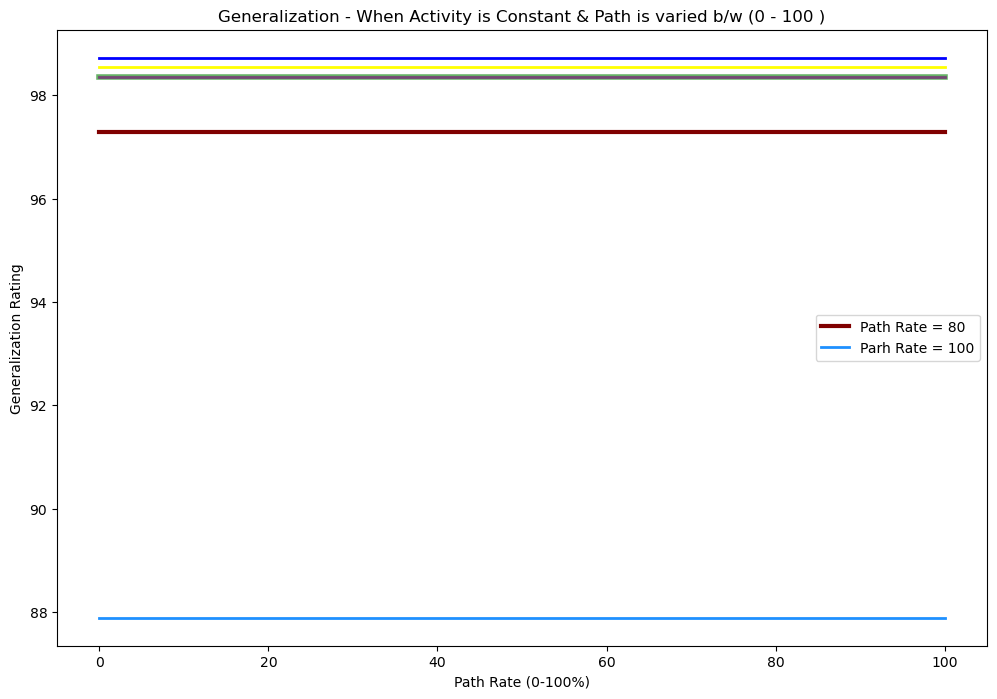

In [17]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df0, lw = 2, color = 'blue')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df1, lw = 2, color = 'yellow')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df2, lw = 4, alpha = 0.6, color = 'green')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df3, lw = 2, alpha = 0.6, color = 'purple')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df4, lw = 3, label = "Path Rate = 80", color = 'maroon')
sns.lineplot(x='Activity_rate', y='Generalization', data=res_df5, lw = 2, label = "Parh Rate = 100", color = 'dodgerblue')
#sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, re['Activity_Rate']), lw = 2)
plt.xlabel("Path Rate (0-100%)")
plt.ylabel("Generalization Rating")
plt.title("Generalization - When Activity is Constant & Path is varied b/w (0 - 100 )")
plt.show()

### Saving to CSV File

In [ ]:
PATH_FULL.to_csv("Sample_5_Generalization_PATH.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(Path_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Path is kept Constant & Varied b/w (0 - 100 )")
plt.show()

-------------

-------------